In [1]:
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, LogNorm
import numpy as np
import sys 
import os
import h5py
# from torreylabtools import helpers
import arepo_package
from astropy import constants as c
from astropy import units as u
from LtU_get_property import get_particle_property_LTU
from astropy.cosmology import Planck18 as cosmo

%matplotlib inline

In [2]:
os.environ["MANPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/man:" + os.environ.get("MANPATH", "")
os.environ["INFOPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/info:" + os.environ.get("INFOPATH", "")
os.environ["PATH"] = "/standard/torrey-group/Share/texlive/2018/bin/x86_64-linux:/standard/torrey-group/Share/texlive/2018/texmf-dist:" + os.environ.get("PATH", "")

# Bondi

In [3]:
Filepath = '/project/torrey-group/jkho/LtU_accretion'  # '/project/torrey-group/jkho/LtU_accretion/Low_mass_seeds' 
Box = 'Constrained'
Simpath = 'FF_constrained_AGN_fewseeds_stellar' # 'Bondi_constrained_noAGN_0.1stellar'# 'FF_zoom' # 'Bondi_lowmass_noAGN_fewseeds_z127' # 'Bondi_lowmass_noAGN_z127' 
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'
basePath = f'{Filepath}/{Box}/{Simpath}/{outputpath}/'
redshifts = np.linspace(19,6,14)
a = 1/(1+redshifts)
i = 0
# BH_QM = get_particle_property_LTU(basePath,'BH_CumEgyInjection_QM',p_type=5, desired_redshift = redshifts[i])
# BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])

In [4]:
redshifts[i]

np.float64(19.0)

In [ ]:
BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])

In [ ]:
Filepath = '/project/torrey-group/jkho/LtU_accretion'  # '/project/torrey-group/jkho/LtU_accretion/Low_mass_seeds' 
Box = 'Constrained'
Simpath = 'FF_constrained_AGN_fewseeds_stellar' # 'Bondi_constrained_noAGN_0.1stellar'# 'FF_zoom' # 'Bondi_lowmass_noAGN_fewseeds_z127' # 'Bondi_lowmass_noAGN_z127' 
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'
basePath = f'{Filepath}/{Box}/{Simpath}/{outputpath}/'

# header = arepo_package.load_snapshot_header(basePath,6)
# boxsize = header['BoxSize']
h = 0.6774

GAMMA=5./3
GAMMA_MINUS1=GAMMA-1
redshifts = np.linspace(19,6,14)
a = 1/(1+redshifts)
bondi_boost = 100

Masses = []
Mdots = []
SoundSpeed_space = []
Densities = []
Eddington_Rates = []

for i in range(len(redshifts)):
    print(f'Loading redshift {redshifts[i]}')
    
    BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
    BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
    BH_rhos = get_particle_property_LTU(basePath,'BH_Density',p_type=5, desired_redshift = redshifts[i])
    BH_U = get_particle_property_LTU(basePath,'BH_U',p_type=5, desired_redshift = redshifts[i])
    BH_Eddington = get_particle_property_LTU(basePath,'BH_MdotEddington',p_type=5, desired_redshift = redshifts[i])
    
    most_massive_ind = np.argmax(BH_Mass[0])
    
    SoundSpeed_space.append(np.sqrt(GAMMA * GAMMA_MINUS1 * BH_U[0][most_massive_ind])) # Units: km/s
    Densities.append(BH_rhos[0][most_massive_ind] * (1e10/h)/(a[i]/h)**3) # Units: solar masses/kpc^3
    Masses.append(BH_Mass[0][most_massive_ind]*1e10/h)
    Mdots.append(BH_Mdot[0][most_massive_ind]*1e10/0.978)
    Eddington_Rates.append(BH_Eddington[0][most_massive_ind]*1e10/0.978)

G = c.G.to(u.km**3/(u.Msun*u.s**2)).value
f_env = np.array(SoundSpeed_space)**3/(4*np.pi*G**2*np.array(Densities)/c.kpc.to(u.km).value**3) * (1/u.Gyr.to(u.s)) # Units: Msun*Gyr

specific = []

for i in range(len(redshifts)):

    rate = Masses[i]/f_env[i]
    
    specific.append(rate*bondi_boost)


Loading redshift 19.0


In [ ]:
fig,axs = plt.subplots(3,1,figsize = (8,10),sharex = True)

Accretion_rates = [np.min([np.array(specific_accretion[i]),Eddington_Rates[i]/np.array(Masses[i])]) for i in range(len(redshifts))]

axs[0].scatter(redshifts,np.array(Mdots)/np.array(Masses),label = r'Explicit $\dot{M}/M_{\rm BH}$')
axs[0].scatter(redshifts,Accretion_rates,label = 'Environmentally calculated',s=15,alpha=0.5)
axs[0].set_yscale('log')
axs[0].set_ylabel('Specific Accretion rate [1/Gyr]',size=15)
axs[0].legend()

axs[1].scatter(redshifts,Densities)
axs[1].set_ylabel(r'Gas density $\rm [M_\odot/kpc^3]$',size=15)
axs[1].set_xlabel('Redshift',size=15)

axs[2].scatter(redshifts,SoundSpeed_space,color='green')
axs[2].set_yscale('log')
axs[2].set_ylabel(r'Sound speed [$\rm km/s$]',size=12)

fig.tight_layout()
plt.subplots_adjust(hspace=0)

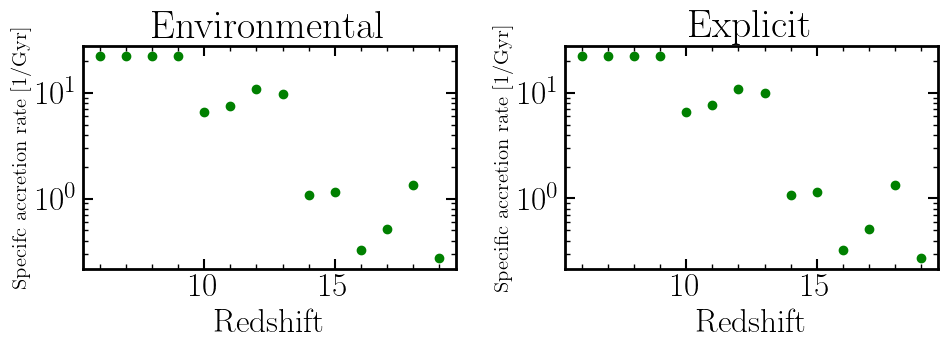

In [8]:
fig,axs = plt.subplots(1,2,figsize=(10,4))

Accretion_rates = [np.min([np.array(specific[i]),Eddington_Rates[i]/np.array(Masses[i])]) for i in range(len(redshifts))]

axs[0].scatter(redshifts,Accretion_rates,label=r'$M_{\rm seed} = 1e5 M_\odot$',color='green')
axs[0].set_yscale('log')
axs[0].set_xlabel('Redshift')
axs[0].set_ylabel(r'Specifc accretion rate [$\rm 1/Gyr$]',size=15)
axs[0].set_title('Environmental')

axs[1].scatter(redshifts,np.array(Mdots)/np.array(Masses),color='green')
axs[1].set_yscale('log')
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel(r'Specific accretion rate [$\rm 1/Gyr$]',size=15)
axs[1].set_title('Explicit')

fig.tight_layout()


In [ ]:
fig,axs = plt.subplots(4,1,figsize=(8,12),sharex = True)

Accretion_rates = [np.min([np.array(specific[i]),Eddington_Rates[i]/np.array(Masses[i])]) for i in range(len(redshifts))]

axs[0].scatter(redshifts,Accretion_rates,label=r'$M_{\rm seed} = 1e5 M_\odot$',color='green')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'Specifc accretion rate [$\rm 1/Gyr$]',size=12)

axs[1].scatter(redshifts,Densities,color='green')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'Densities [$\rm M_\odot/kpc^3$]',size=12)

axs[2].scatter(redshifts,SoundSpeed_space,color='green')
axs[2].set_yscale('log')
axs[2].set_ylabel(r'Sound speed [$\rm km/s$]',size=12)

axs[3].scatter(redshifts,Masses,label=r'$M_{\rm seed} = 1e5 M_\odot$',color='green')
axs[3].set_yscale('log')
axs[3].set_xlabel('Redshift')
axs[3].set_ylabel(r'BH Mass [$\rm M_\odot$]',size=12)

# for ax in axs:
#     ax.set_ylim(1e3,5e15)

# fig.suptitle(f'{Sim_folder}',y=0.95)
# fig.legend(fontsize=10,loc=(0.575,0.75))

fig.tight_layout()
plt.subplots_adjust(hspace=0)

fig.savefig(f'Plots/{Simpath}_components.png')


# Freefall

In [ ]:
Filepath = '/project/torrey-group/jkho/LtU_accretion'  # '/project/torrey-group/jkho/LtU_accretion/Low_mass_seeds' 
Box = 'Low_mass_seeds'
Simpath = 'FF_lowmass_noAGN_fewseeds_z127'# 'FF_zoom' # 'Bondi_lowmass_noAGN_fewseeds_z127' # 'Bondi_lowmass_noAGN_z127' 
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'
basePath = f'{Filepath}/{Box}/{Simpath}/{outputpath}/'

header = arepo_package.load_snapshot_header(basePath,6)
boxsize = header['BoxSize']
h = 0.6774

GAMMA=5./3
GAMMA_MINUS1=GAMMA-1
redshifts = np.linspace(15,6,10)
a = 1/(1+redshifts)

Masses = []
Mdots = []
SoundSpeed_space = []
Densities = []
# all_accretion = []
accretion_masses = []
accretion_pos = []

for i in range(len(redshifts)):

    print(f"Currently loading redshift {redshifts[i]}")

    d = 0.140 # kpc

    BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
    BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
    BH_rhos = get_particle_property_LTU(basePath,'BH_Density',p_type=5, desired_redshift = redshifts[i])
    BH_U = get_particle_property_LTU(basePath,'BH_U',p_type=5, desired_redshift = redshifts[i])

    Gas_Mass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = redshifts[i])
    Gas_Pos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = redshifts[i])
    BH_Pos = get_particle_property_LTU(basePath,'Coordinates',p_type=5, desired_redshift = redshifts[i])
    
    most_massive_ind = np.argmax(BH_Mass[0])

    BH_pos = BH_Pos[0][most_massive_ind] * a[i]/h # kpc
    Gas_pos = Gas_Pos[0] * a[i]/h # kpc

    distances = np.linalg.norm(Gas_pos - BH_pos,axis=1)
    Contributing_gas_mask = distances < d # Only gas cells within a distance d of the BH contribute to accretion
    
    # print(f"Minimum distance: {np.min(distances)} kpc")
    
    if np.sum(Gas_Mass[0][Contributing_gas_mask] * 1e10/h) > 0:
        Total_mgas = Gas_Mass[0][Contributing_gas_mask] * 1e10/h # Msun
    else:
        Total_mgas = Gas_Mass[0][np.argmin(distances)] * 1e10/h
    
    SoundSpeed_space.append(np.sqrt(GAMMA * GAMMA_MINUS1 * BH_U[0][most_massive_ind])) # Units: km/s
    Densities.append(BH_rhos[0][most_massive_ind] * (1e10/h)/(a[i]/h)**3) # Units: solar masses/kpc^3
    Masses.append(BH_Mass[0][most_massive_ind]*1e10/h)
    Mdots.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Solar masses/Gyr
    # all_accretion.append( (np.sum(BH_QM_Cumgrowth[0])+np.sum(BH_QM_Cumgrowth[0])) * 1e10/h) 
    accretion_masses.append(Total_mgas)
    accretion_pos.append(distances[Contributing_gas_mask])

In [ ]:
G = c.G.to(u.km**3/(u.Msun*u.Gyr**2)).value
light_speed = c.c.to(u.km/u.Gyr).value
kpc2km = u.kpc.to(u.km)
# sec_per_Gyr = u.Gyr.to(u.s)

# modff:
# specific_accretion = sec_per_Gyr*np.array([100*np.sqrt(2) * G/light_speed * np.sum(accretion_masses[i])/(d*kpc2km)**2 for i in range(len(redshifts))])

# ff:
specific_accretion = 0.001*np.sqrt(G/(np.array(Masses)))/(d*kpc2km)**(3/2)*np.array([np.sum(accretion_masses[i]) for i in range(len(redshifts))])


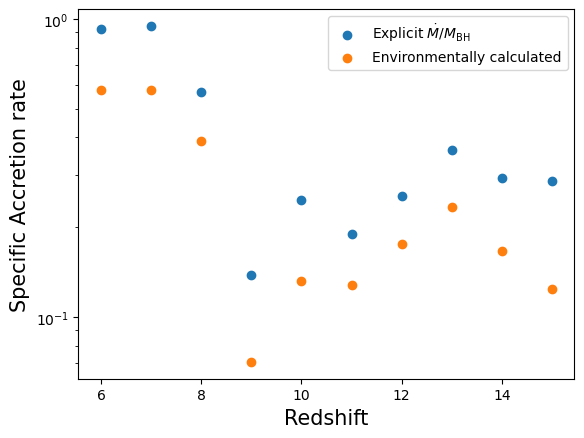

In [23]:
fig,axs = plt.subplots(3,1,figsize = (8,10))

axs[0].scatter(redshifts,np.array(Mdots)/np.array(Masses),label = r'Explicit $\dot{M}/M_{\rm BH}$')
axs[0].scatter(redshifts,specific_accretion,label = 'Environmentally calculated')
axs[0].yscale('log')
axs[0].ylabel('Specific Accretion rate',size=15)
axs[0].xlabel('Redshift',size=15)
axs[0].legend()

densities = np.array([np.sum(accretion_masses[i]) for i in range(len(redshifts))])/((4/3)*np.pi*(d)**3)
axs[1].scatter(redshifts,densities)
axs[1].ylabel(r'Gas density within d $\rm [M_\odot/kpc^3]$',size=15)
axs[1].xlabel('Redshift',size=15)

# plt.savefig(f'{Simpath}/Plots/Specific_accretion_comparison_ff_r140.png')


Text(0.5, 0, 'Redshift')

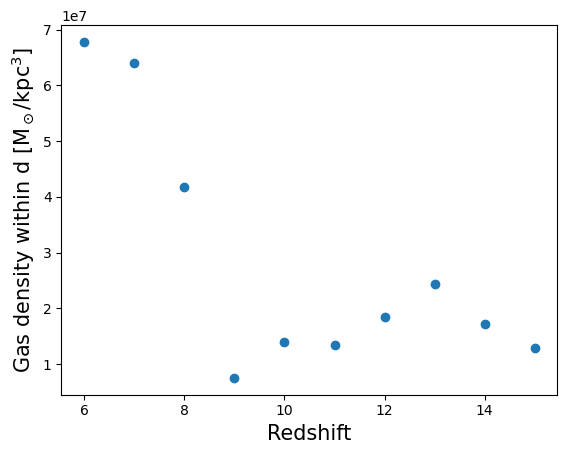

In [36]:
densities = np.array([np.sum(accretion_masses[i]) for i in range(len(redshifts))])/((4/3)*np.pi*(d)**3)
plt.scatter(redshifts,densities)

# plt.yscale('log')
plt.ylabel(r'Gas density within d $\rm [M_\odot/kpc^3]$',size=15)
plt.xlabel('Redshift',size=15)

# modff

In [40]:
Filepath = '/project/torrey-group/jkho/LtU_accretion'  # '/project/torrey-group/jkho/LtU_accretion/Low_mass_seeds' 
Box = 'Low_mass_seeds'
Simpath = 'modFF_lowmass_noAGN_fewseeds_z127'# 'FF_zoom' # 'Bondi_lowmass_noAGN_fewseeds_z127' # 'Bondi_lowmass_noAGN_z127' 
outputpath = 'output'  # 'Bondi_seed3.19_nofeedback_fewseeds'
basePath = f'{Filepath}/{Box}/{Simpath}/{outputpath}/'

header = arepo_package.load_snapshot_header(basePath,6)
boxsize = header['BoxSize']
h = 0.6774

GAMMA=5./3
GAMMA_MINUS1=GAMMA-1
redshifts = np.linspace(15,6,10)
a = 1/(1+redshifts)

Masses = []
Mdots = []
SoundSpeed_space = []
Densities = []
# all_accretion = []
accretion_masses = []
accretion_pos = []

for i in range(len(redshifts)):

    print(f"Currently loading redshift {redshifts[i]}")

    d = 0.140 # kpc

    BH_Mass = get_particle_property_LTU(basePath,'BH_Mass',p_type=5, desired_redshift = redshifts[i])
    BH_Mdot = get_particle_property_LTU(basePath,'BH_Mdot',p_type=5, desired_redshift = redshifts[i])
    BH_rhos = get_particle_property_LTU(basePath,'BH_Density',p_type=5, desired_redshift = redshifts[i])
    BH_U = get_particle_property_LTU(basePath,'BH_U',p_type=5, desired_redshift = redshifts[i])

    Gas_Mass = get_particle_property_LTU(basePath,'Masses',p_type=0, desired_redshift = redshifts[i])
    Gas_Pos = get_particle_property_LTU(basePath,'Coordinates',p_type=0, desired_redshift = redshifts[i])
    BH_Pos = get_particle_property_LTU(basePath,'Coordinates',p_type=5, desired_redshift = redshifts[i])
    
    most_massive_ind = np.argmax(BH_Mass[0])

    BH_pos = BH_Pos[0][most_massive_ind] * a[i]/h # kpc
    Gas_pos = Gas_Pos[0] * a[i]/h # kpc

    distances = np.linalg.norm(Gas_pos - BH_pos,axis=1)
    Contributing_gas_mask = distances < d # Only gas cells within a distance d of the BH contribute to accretion
    
    # print(f"Minimum distance: {np.min(distances)} kpc")
    
    if np.sum(Gas_Mass[0][Contributing_gas_mask] * 1e10/h) > 0:
        Total_mgas = Gas_Mass[0][Contributing_gas_mask] * 1e10/h # Msun
    else:
        Total_mgas = Gas_Mass[0][np.argmin(distances)] * 1e10/h
    
    SoundSpeed_space.append(np.sqrt(GAMMA * GAMMA_MINUS1 * BH_U[0][most_massive_ind])) # Units: km/s
    Densities.append(BH_rhos[0][most_massive_ind] * (1e10/h)/(a[i]/h)**3) # Units: solar masses/kpc^3
    Masses.append(BH_Mass[0][most_massive_ind]*1e10/h)
    Mdots.append(BH_Mdot[0][most_massive_ind]*1e10/0.978) # Solar masses/Gyr
    # all_accretion.append( (np.sum(BH_QM_Cumgrowth[0])+np.sum(BH_QM_Cumgrowth[0])) * 1e10/h) 
    accretion_masses.append(Total_mgas)
    accretion_pos.append(distances[Contributing_gas_mask])

Desired redshift:  6
Output redshift:  6.0107573988449
Output snapshot:  19
Currently loading redshift 15.0
Currently loading redshift 14.0
Currently loading redshift 13.0
Currently loading redshift 12.0
Currently loading redshift 11.0
Currently loading redshift 10.0
Currently loading redshift 9.0
Currently loading redshift 8.0
Currently loading redshift 7.0
Currently loading redshift 6.0


In [41]:
G = c.G.to(u.km**3/(u.Msun*u.s**2)).value
light_speed = c.c.to(u.km/u.s).value
kpc2km = u.kpc.to(u.km)
sec_per_Gyr = u.Gyr.to(u.s)

# modff:
specific_accretion = sec_per_Gyr*np.array([100*np.sqrt(2) * G/light_speed * np.sum(accretion_masses[i])/(d*kpc2km)**2 for i in range(len(redshifts))])

# ff:
# specific_accretion = sec_per_Gyr*0.001*np.sqrt(G/(Masses*d**3))*np.array([np.sum(accretion_masses[i]) for i in range(len(redshifts))])


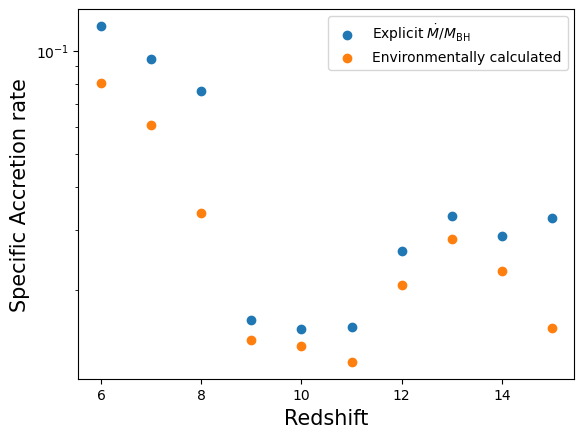

In [45]:
plt.scatter(redshifts,np.array(Mdots)/np.array(Masses),label = r'Explicit $\dot{M}/M_{\rm BH}$')
plt.scatter(redshifts,specific_accretion,label = 'Environmentally calculated')
plt.yscale('log')
plt.ylabel('Specific Accretion rate',size=15)
plt.xlabel('Redshift',size=15)
plt.legend()
plt.savefig(f'Plots/{Simpath}_Specific_accretion_comparison_modff_r140.png')


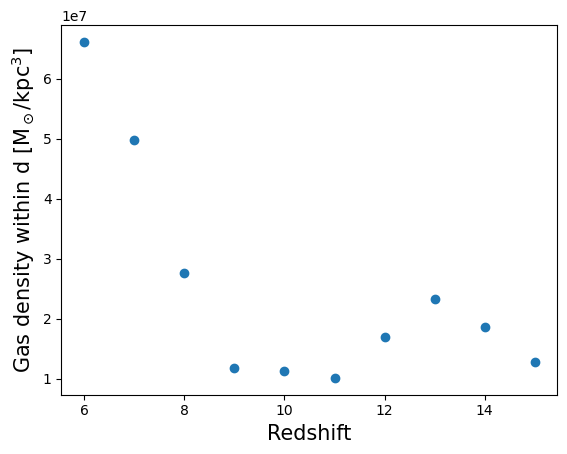

In [46]:
densities = np.array([np.sum(accretion_masses[i]) for i in range(len(redshifts))])/((4/3)*np.pi*(d)**3)
plt.scatter(redshifts,densities)

# plt.yscale('log')
plt.ylabel(r'Gas density within d $\rm [M_\odot/kpc^3]$',size=15)
plt.xlabel('Redshift',size=15)
plt.savefig(f'Plots/{Simpath}_density_modff_r140.png')
